Nutrient comparisons with edited dataset using surface instead of 2m for depth.

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools, nc_tools
import pytz
import os
import glob
%matplotlib inline

In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
#load model grid stuff
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [3]:
# Load CitSci data and clean it up
nutrients_2015 = pd.read_excel('/home/vdo/Downloads/PSFbottledata_CN_edits.xlsx')
nutrients_2015 = nutrients_2015.dropna(axis ='index', how = 'any')
datetimes = np.array([datetime.datetime.combine(pd.to_datetime(nutrients_2015['date'][index]),
                                      nutrients_2015['Time'][index]) 
                      for index in nutrients_2015.index])
nutrients_2015 = nutrients_2015.assign(datetime = datetimes)
local = pytz.timezone ("America/Los_Angeles")
utc_datetimes = np.array([local.localize(nutrients_2015['datetime'][index], 
                                         is_dst=None).astimezone(pytz.utc)
                          for index in nutrients_2015.index])
nutrients_2015 = nutrients_2015.assign(utc_datetime = utc_datetimes)
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)
nutrients_2015 = nutrients_2015.dropna(axis ='index', how = 'any')

In [4]:
nutrients_2015.shape

(818, 14)

In [5]:
# load model data and load it into arrays
model_nutrients = sorted(glob.glob(
    '/ocean/vdo/MEOPAR/completed-runs/smelt1/test*/SalishSea*1h*ptrc*'))

In [6]:
with nc_tools.scDataset(model_nutrients) as f: #takes a while to run, prone to killing kernal
    times = f.variables['time_counter'][:]
    print('times is done')
    model_si = f.variables['silicon'][:, :19, ...]
    print('Si is done')
    model_n023 = f.variables['nitrate'][:, :19, ...]
    print('Nitrate is done')

times is done
Si is done
Nitrate is done


In [7]:
h = nc.Dataset(model_nutrients[0])

In [8]:
# convert into datetime
converted_timesa = nc.num2date(times, h.variables['time_counter'].units)

In [9]:
# mask everything outside of daterange of modelled results 
# apply same mask to everything in CS data
dates = nutrients_2015['utc_datetime'].values
dates = np.array([pd.to_datetime(dates[n]) for n in range(818)])
dates = np.ma.masked_outside(dates, datetime.datetime(2015,1,31), datetime.datetime(2015,5,2))
Yinds = np.ma.masked_array(nutrients_2015['Yind'].values, mask = dates.mask)
Xinds = np.ma.masked_array(nutrients_2015['Xind'].values, mask = dates.mask)
depths = np.ma.masked_array(nutrients_2015['depth'].values, mask = dates.mask)
cs_si = np.ma.masked_array(nutrients_2015['si'].values, mask = dates.mask)
cs_no23 = np.ma.masked_array(nutrients_2015['no23'].values, mask = dates.mask)

In [10]:
np.ma.count(cs_si)

276

In [11]:
list_of_model_si = np.ma.masked_array(np.zeros((818)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((818)), mask = True)
t = 0
for n in range(818):
    if dates.mask[n] == False:
        Yind = Yinds[n]
        Xind = Xinds[n]
        date = dates[n]
        if ((depths[n] == 20) and (mesh.variables['tmask'][0,18,Yind,Xind] == 1)):
            if date.minute <= 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
                delta = (date - before).seconds / 3600
                index = np.argmin(np.abs(converted_timesa - date))
                s_val = ((delta * (model_si[index, 18, Yind, Xind])) + 
                       (1- delta)*(model_si[index, 18, Yind, Xind]))
                n_val = ((delta * (model_n023[index-1, 18,Yind, Xind])) + 
                       (1- delta)*(model_n023[index, 18, Yind, Xind]))
            if date.minute > 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                       hour = (date.hour), minute = 30)
                delta = (date - before).seconds / 3600
                index = np.argmin(np.abs(converted_timesa - date))
                s_val = ((delta * (model_si[index, 18,Yind, Xind])) + 
                       (1- delta)*(model_si[index+1,18, Yind, Xind]))
                n_val = ((delta * (model_n023[index, 18, Yind, Xind])) + 
                       (1- delta)*(model_n023[index+1, 18,Yind, Xind]))
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = s_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = n_val
        if ((depths[n] == 2) and (mesh.variables['tmask'][0,0,Yind,Xind] == 1)):
            if date.minute <= 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
                delta = (date - before).seconds / 3600
                index = np.argmin(np.abs(converted_timesa - date))
                s_val = ((delta * (model_si[index-1, 0, Yind, Xind])) + 
                       (1- delta)*(model_si[index, 0, Yind, Xind]))
                n_val = ((delta * (model_n023[index-1, 0,Yind, Xind])) + 
                       (1- delta)*(model_n023[index, 0, Yind, Xind]))
            if date.minute > 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                       hour = (date.hour), minute = 30)
                delta = (date - before).seconds / 3600
                index = np.argmin(np.abs(converted_timesa - date))
                s_val = ((delta * (model_si[index, 0,Yind, Xind])) + 
                       (1- delta)*(model_si[index+1,0, Yind, Xind]))
                n_val = ((delta * (model_n023[index, 0, Yind, Xind])) + 
                       (1- delta)*(model_n023[index+1, 0,Yind, Xind]))
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = s_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = n_val
    t = t + 1

/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__

In [12]:
cs_no23.mask = list_of_model_ni.mask
cs_si.mask = list_of_model_si.mask

In [13]:
np.ma.count(cs_no23)

271

bias =  -2.93025214592
RMSE = 4.06476949187
Willmott = 0.839752152046


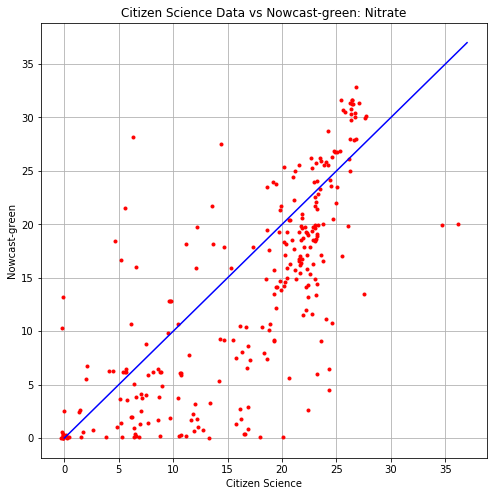

In [14]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_no23, list_of_model_ni, 'r.')
ax.plot(np.arange(0,38), np.arange(0,38), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_no23) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - cs_no23)**2) /
                              807)))
xbar = np.mean(cs_no23)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - cs_no23)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(cs_no23 - xbar))**2))))

bias =  0.159050827026
RMSE = 9.23288558206
Willmott = 0.584393231976


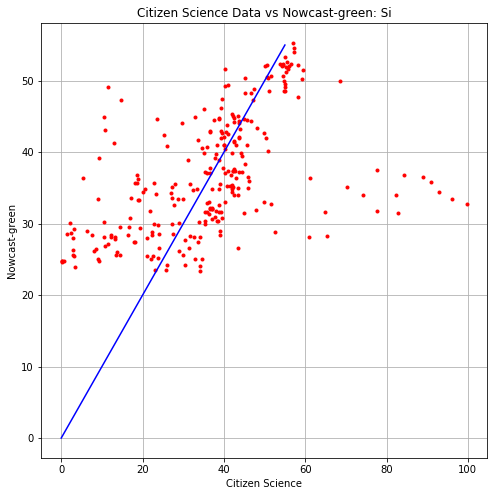

In [15]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_si, list_of_model_si, 'r.')
ax.plot(np.arange(0,56), np.arange(0,56), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - cs_si)**2) /
                              807)))
xbar = np.mean(cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(cs_si - xbar))**2))))

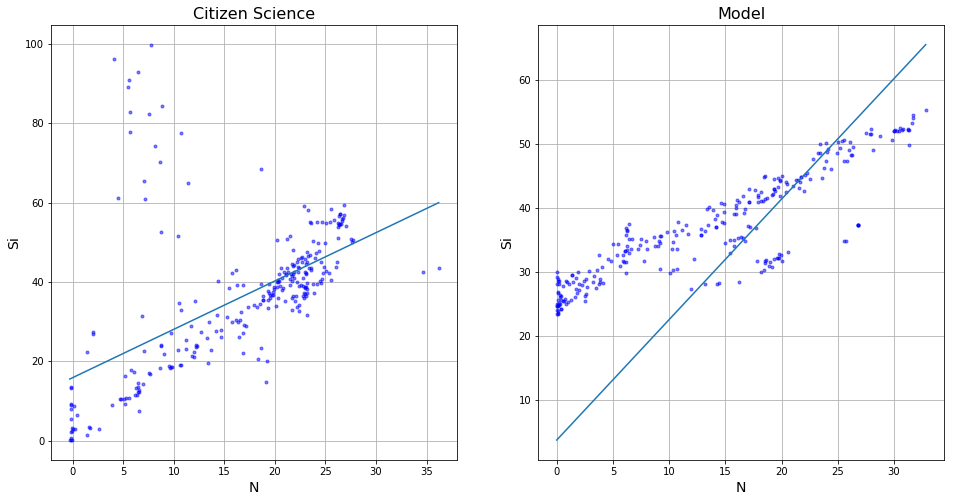

In [16]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(cs_no23, cs_si, 'b.', alpha = 0.5)
ax[0].plot(np.unique(cs_no23), np.poly1d(np.polyfit(cs_no23, cs_si, 1))(np.unique(cs_no23)))
x = np.arange(0,37)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
#ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[1].plot(list_of_model_ni, list_of_model_si, 'b.', alpha = 0.5)
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
#ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
#plt.legend();

In [17]:
m1, b1 = np.polyfit(cs_no23, cs_si, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.21836179468
CitSci y int = 15.8608155123
model slope = 1.88456662978
model y int = 3.68642917859
